In [1]:
## 1

import sqlite3
import os


db_filename = 'stadium.db'
conn = sqlite3.connect(db_filename)
cursor = conn.cursor()

In [2]:
# 2

cursor.execute("DROP TABLE IF EXISTS games;")

sql_create_games = """
CREATE TABLE games (
    game_id TEXT PRIMARY KEY,
    season INTEGER NOT NULL,
    week INTEGER NOT NULL,
    date TEXT NOT NULL,
    opponent TEXT NOT NULL,
    home_score INTEGER,
    away_score INTEGER,
    
  
    attendance INTEGER, 
    
    temp REAL,
    wind REAL,
    roof TEXT,
    surface TEXT,
    spread_line REAL,
    total_line REAL
);
"""

cursor.execute(sql_create_games)
conn.commit()

In [3]:
# 3

# SQL to create sales table
cursor.execute("DROP TABLE IF EXISTS sales;")

sql_create_sales = """
CREATE TABLE sales (
    sale_id INTEGER PRIMARY KEY,
    game_id TEXT NOT NULL,
    item TEXT NOT NULL,
    quantity INTEGER NOT NULL,
    revenue REAL NOT NULL,
    is_4th_qtr INTEGER NOT NULL,
    FOREIGN KEY (game_id) REFERENCES games(game_id)

); """

cursor.execute(sql_create_sales)
conn.commit()

In [4]:
# 4

# Phase 2.5: The Web Scraper
# We need real attendance to make the model valid.
import pandas as pd

# 1. Define the URL (ESPN has great attendance tables)
url_2024 = "https://www.espn.com/nfl/attendance/_/year/2024"
url_2023 = "https://www.espn.com/nfl/attendance/_/year/2023"

# 2. Scrape the tables
# pd.read_html scans the website and returns all tables it finds as DataFrames
print("Scraping ESPN for real attendance data...")
tables_2024 = pd.read_html(url_2024)
tables_2023 = pd.read_html(url_2023)

# 3. Inspect the result
# Usually the first table is the one we want
attendance_2024 = tables_2024[0]
attendance_2023 = tables_2023[0]

# Add a year column so we can track it
attendance_2024['season'] = 2024
attendance_2023['season'] = 2023

# Combine them
real_attendance_df = pd.concat([attendance_2024, attendance_2023])

print(real_attendance_df.head())

Scraping ESPN for real attendance data...
                 0                1     2       3      4     5       6      7  \
0  2024 Attendance  2024 Attendance  Home    Home   Home  Road    Road   Road   
1               RK             TEAM   GMS   TOTAL    AVG   GMS   TOTAL    AVG   
2                1           Dallas     9  836749  92972     8  564826  70603   
3                2          NY Jets     7  551528  78789     9  593347  65927   
4                3        NY Giants     9  706231  78470     8  567411  70926   

         8        9       10  season  
0  Overall  Overall  Overall    2024  
1      GMS    TOTAL      AVG    2024  
2       17  1401575    82445    2024  
3       16  1144875    71554    2024  
4       17  1273642    74920    2024  


In [5]:
# --- PHASE 2.5: SCRAPE & CLEAN ATTENDANCE ---

# 1. Scrape (Same as before)
url_2024 = "https://www.espn.com/nfl/attendance/_/year/2024"
url_2023 = "https://www.espn.com/nfl/attendance/_/year/2023"
attendance_2024 = pd.read_html(url_2024)[0]
attendance_2023 = pd.read_html(url_2023)[0]
attendance_2024['season'] = 2024
attendance_2023['season'] = 2023
real_attendance_df = pd.concat([attendance_2024, attendance_2023])

# 2. Fix Column Names
real_attendance_df.columns = ['rank', 'team_name', 'home_games', 'home_total', 'home_avg', 'road_games', 'road_total', 'road_avg', 'overall_games', 'overall_total', 'overall_avg', 'season']

# 3. Drop Header Rows
real_attendance_df = real_attendance_df[pd.to_numeric(real_attendance_df['rank'], errors='coerce').notnull()].copy()

# 4. Map Team Names
team_map = {
    'Seattle': 'SEA', 'San Francisco': 'SF', 'Arizona': 'ARI', 'LA Rams': 'LA', 
    'Dallas': 'DAL', 'Philadelphia': 'PHI', 'NY Giants': 'NYG', 'Washington': 'WAS',
    'Chicago': 'CHI', 'Detroit': 'DET', 'Green Bay': 'GB', 'Minnesota': 'MIN',
    'Tampa Bay': 'TB', 'New Orleans': 'NO', 'Atlanta': 'ATL', 'Carolina': 'CAR',
    'Buffalo': 'BUF', 'Miami': 'MIA', 'New England': 'NE', 'NY Jets': 'NYJ',
    'Kansas City': 'KC', 'Las Vegas': 'LV', 'Denver': 'DEN', 'LA Chargers': 'LAC',
    'Baltimore': 'BAL', 'Pittsburgh': 'PIT', 'Cleveland': 'CLE', 'Cincinnati': 'CIN',
    'Houston': 'HOU', 'Indianapolis': 'IND', 'Jacksonville': 'JAX', 'Tennessee': 'TEN'
}
real_attendance_df['home_team'] = real_attendance_df['team_name'].map(team_map)

# 5. FIX: Handle Dashes and Convert to Numeric
# We coerce errors to NaN, which handles the '-' automatically
real_attendance_df['attendance_real'] = pd.to_numeric(real_attendance_df['home_avg'].astype(str).str.replace(',', ''), errors='coerce')

# 6. Final Selection
attendance_clean = real_attendance_df[['season', 'home_team', 'attendance_real']].dropna()

print("✅ Attendance Data Cleaned! Rows available:", len(attendance_clean))

✅ Attendance Data Cleaned! Rows available: 55


In [6]:
# --- FINAL V3 ETL PIPELINE: GAMES TABLE ---

import nfl_data_py as nfl
import pandas as pd
import numpy as np

# --- 1. DEFINE ATTENDANCE LOGIC (The "Feature Engineering") ---
def adjust_attendance(row):
    # Start with the scraped season average
    base_att = row['attendance']
    
    # Safety check: if attendance is missing/NaN, default to 68,000
    if pd.isna(base_att):
        base_att = 68000
    
    # A. Rivalry Bump (NFC West Rivals)
    # Games against 49ers, Rams, Cardinals draw more fans
    if row['away_team'] in ['SF', 'LA', 'ARI']:
        base_att *= 1.03 # +3%
        
    # B. "Big Game" Bump (Top Tier / Popular Teams)
    if row['away_team'] in ['KC', 'BUF', 'DET', 'PHI', 'DAL', 'PIT']:
        base_att *= 1.05 # +5%
        
    # C. Seasonality / Weather Drop (Late Season)
    # Week 15+ in Seattle is cold/rainy; casual fans stay home
    if row['week'] >= 15:
        base_att *= 0.96 # -4%
        
    # D. Random Noise (Real life isn't perfect)
    # Add +/- 2% random variance to prevent identical numbers
    noise = np.random.uniform(0.98, 1.02)
    base_att *= noise
    
    # E. Cap at Stadium Capacity
    # Lumen Field max capacity is approx 69,000 (expandable to 72k for huge events)
    return min(base_att, 72000)

# --- 2. EXTRACT: Pull Schedule Data ---
years_to_pull = [2024, 2025]
schedule_df = nfl.import_schedules(years_to_pull)

# --- 3. TRANSFORM: Filter for Seahawks Home Games ---
schedule_df = schedule_df[schedule_df['home_team'] == 'SEA'].copy()

# --- 4. MERGE: Add Real Attendance Data ---
# Join on Season and Home Team to get the scraped average
schedule_df = schedule_df.merge(attendance_clean, on=['season', 'home_team'], how='left')

# Rename the merged column for clarity
schedule_df = schedule_df.rename(columns={'attendance_real': 'attendance'})

# --- 5. APPLY LOGIC: Create Variance ---
# Apply the function row-by-row
schedule_df['attendance'] = schedule_df.apply(adjust_attendance, axis=1)

# --- 6. TRANSFORM: Final Selection & Renaming ---
# Select only the columns we defined in our SQL Schema
schedule_df = schedule_df[[
    'game_id', 'season', 'week', 'gameday', 'away_team', 
    'home_score', 'away_score', 'temp', 'wind', 'roof', 'surface', 
    'spread_line', 'total_line', 'attendance'
]].rename(
    columns={
        'gameday': 'date',
        'away_team': 'opponent',
        'gametime': 'kickoff_time' 
        # Note: kickoff_time/network aren't in import_schedules, so we add placeholders below
    }
)

# --- 7. CLEANUP: Handle Placeholders ---
schedule_df['kickoff_time'] = '00:00:00' # Placeholder
schedule_df['network'] = 'Unknown'       # Placeholder
schedule_df['is_home_game'] = 1 
# Ensure date format is clean string
schedule_df['date'] = schedule_df['date'].astype(str).str[:10]

# --- 8. LOAD: Write to SQL ---
# Wipe the old 2490 rows and load the correct 17 rows with varied attendance
schedule_df.to_sql('games', conn, if_exists='replace', index=False)

print(f"✅ SUCCESS! Loaded {len(schedule_df)} games.")
print("Sample of Varied Attendance:")
print(schedule_df[['date', 'opponent', 'attendance', 'temp']].head())

✅ SUCCESS! Loaded 17 games.
Sample of Varied Attendance:
         date opponent    attendance  temp
0  2024-09-08      DEN  67900.187046  65.0
1  2024-09-22      MIA  69150.833842  64.0
2  2024-10-06      NYG  68669.234974  61.0
3  2024-10-10       SF  69749.481457  59.0
4  2024-10-27      BUF  70843.644057  55.0


In [7]:
## CELL 8

import numpy as np
import pandas as pd

# Updated arguments to include Vegas context
def generate_game_sales(game_id, attendance, spread, total):
    
    # Base Constants
    SALES_PER_FAN = 0.85
    PRICE_NOISE = 0.5
    
    # --- NEW LOGIC: THE VEGAS EFFECT ---
    
    # 1. The "Shootout" Bump (High Over/Under = Excitement)
    # If Total is missing (NaN), treat as average (45)
    if pd.isna(total): total = 45
    
    if total > 48:
        SALES_PER_FAN *= 1.10 # +10% Sales
    elif total < 40:
        SALES_PER_FAN *= 0.95 # -5% Sales (Boring defensive struggle)
        
    # 2. The "Blowout Risk" Drop (High Spread = Boring)
    # If Spread is missing, treat as 0
    if pd.isna(spread): spread = 0
    
    if abs(spread) > 7.5:
        SALES_PER_FAN *= 0.95 # -5% Sales
        
    # -----------------------------------
    
    # 1. Calculate Total Transactions (Now influenced by Vegas!)
    num_sales = int(attendance * SALES_PER_FAN)
    
    # 2. Simulate Score Differential
    simulated_score_diff = np.random.normal(loc=0, scale=10, size=1)
    abs_score_diff = np.abs(simulated_score_diff[0]) 
    
    # 3. Conditional Logic: Crowd Behavior
    if abs_score_diff <= 8:
        Q4_PROBABILITY = 0.45
    elif abs_score_diff <= 18:
        Q4_PROBABILITY = 0.30
    else:
        Q4_PROBABILITY = 0.10
        
    # 4. Simulate Revenue
    revenue_data = np.random.normal(loc=12.50, scale=PRICE_NOISE, size=num_sales)
    revenue_data = np.clip(revenue_data, 0.01, None)
    
    # 5. Simulate Items & Q4 Flag
    item_choices = ['Beer', 'Hot Dog', 'Soda']
    item_probs = [0.50, 0.35, 0.15]
    
    qtr_flag_data = np.random.choice([0, 1], size=num_sales, p=[1 - Q4_PROBABILITY, Q4_PROBABILITY])
    item_data = np.random.choice(item_choices, size=num_sales, p=item_probs)

    # 6. Create DataFrame
    sales_df = pd.DataFrame({
        'game_id': game_id,
        'item': item_data,
        'quantity': 1, 
        'revenue': revenue_data,
        'is_4th_qtr': qtr_flag_data
    })
    
    return sales_df

In [8]:
## CELL 9

import pandas as pd
import numpy as np 
# Assume conn is active

# --- 1. RECREATE SALES TABLE ---
cursor.execute("DROP TABLE IF EXISTS sales;")
sql_create_sales = """
CREATE TABLE sales (
    sale_id INTEGER PRIMARY KEY,
    game_id TEXT NOT NULL,
    item TEXT NOT NULL,
    quantity INTEGER NOT NULL,
    revenue REAL NOT NULL,
    is_4th_qtr INTEGER NOT NULL,
    FOREIGN KEY (game_id) REFERENCES games(game_id)
);
"""
cursor.execute(sql_create_sales)
conn.commit()

# --- 2. DEFINE INPUTS (UPDATED) ---
# We grab spread and total from the DB now!
sql_games_query = 'SELECT game_id, attendance, spread_line, total_line FROM games;'
game_inputs_df = pd.read_sql_query(sql_games_query, conn)

print(f"Loaded {len(game_inputs_df)} games for simulation.")

# --- 3. EXECUTION LOOP ---
print("Starting simulation with Vegas Logic...")

# Global counter for unique sale_ids
global_sale_id_counter = 0
transactions_count = 0 

for row in game_inputs_df.itertuples():
    # Call function with NEW arguments
    simulated_df = generate_game_sales(
        row.game_id, 
        row.attendance, 
        row.spread_line, 
        row.total_line
    )
    
    # Handle sale_id
    batch_size = len(simulated_df)
    simulated_df['sale_id'] = range(global_sale_id_counter, global_sale_id_counter + batch_size)
    global_sale_id_counter += batch_size
    
    # Load to SQL
    simulated_df.to_sql('sales', conn, if_exists='append', index=False)
    
    transactions_count += batch_size

print("\n")
print(f"✅ SIMULATION COMPLETE. Total transactions: {transactions_count:,}")

Loaded 17 games for simulation.
Starting simulation with Vegas Logic...


✅ SIMULATION COMPLETE. Total transactions: 1,003,134


In [9]:
## CELL 10

## PHASE 4: SQL ANALYSIS

sql_q4_analysis = """
SELECT 
    game_id, 
    COUNT (*) as total_sales,
    SUM(is_4th_qtr) as q4_sales,
    CAST(SUM(is_4th_qtr) AS FLOAT) / COUNT(*) as q4_ratio
FROM sales
GROUP BY game_id
ORDER BY q4_ratio DESC;
"""

q4_df = pd.read_sql_query(sql_q4_analysis, conn)
print(q4_df.head(10))


           game_id  total_sales  q4_sales  q4_ratio
0   2025_16_LA_SEA        57468     26008  0.452565
1  2024_03_MIA_SEA        58778     26568  0.452006
2   2024_06_SF_SEA        65215     29469  0.451875
3   2025_01_SF_SEA        58563     26381  0.450472
4   2025_05_TB_SEA        57447     25849  0.449963
5   2025_03_NO_SEA        58366     26202  0.448926
6  2024_08_BUF_SEA        60217     26873  0.446269
7  2025_13_MIN_SEA        58886     17746  0.301362
8   2024_15_GB_SEA        56617     17059  0.301305
9  2024_01_DEN_SEA        57715     17374  0.301031


In [10]:
# Cell 11
## PHASE 4: Data Science (predicting demand)

sql_training_data = """
SELECT
    g.game_id, g.season, g.week, g.opponent, g.temp, g.attendance, g.spread_line, g.total_line,
    COUNT (s.sale_id) as total_sales
FROM games g
JOIN sales s ON g.game_id = s.game_id
GROUP BY g.game_id;
"""

training_df = pd.read_sql_query(sql_training_data, conn)
print(training_df.head(10))



           game_id  season  week opponent  temp    attendance  spread_line  \
0  2024_01_DEN_SEA    2024     1      DEN  65.0  67900.187046          6.5   
1  2024_03_MIA_SEA    2024     3      MIA  64.0  69150.833842          4.0   
2  2024_05_NYG_SEA    2024     5      NYG  61.0  68669.234974          7.0   
3   2024_06_SF_SEA    2024     6       SF  59.0  69749.481457         -3.5   
4  2024_08_BUF_SEA    2024     8      BUF  55.0  70843.644057         -3.0   
5   2024_09_LA_SEA    2024     9       LA  52.0  71817.233849         -1.5   
6  2024_12_ARI_SEA    2024    12      ARI  45.0  71087.196739         -1.0   
7   2024_15_GB_SEA    2024    15       GB  43.0  66609.325175         -3.0   
8  2024_16_MIN_SEA    2024    16      MIN  48.0  64953.804117         -2.5   
9   2025_01_SF_SEA    2025     1       SF  67.0  68898.096484         -2.5   

   total_line  total_sales  
0        42.0        57715  
1        41.5        58778  
2        42.5        58368  
3        49.0        6521

In [11]:
## Cell 12: time-series split (splitting into training (past) and testing (future)

CURRENT_WEEK = 10

train_data = training_df[
    (training_df['season'] == 2024) |
    ((training_df['season'] == 2025) & (training_df['week'] < CURRENT_WEEK))
].copy()

test_data = training_df[
    (training_df['season'] == 2025) &
    (training_df['week'] >= CURRENT_WEEK)
].copy()

features = ['temp', 'week', 'attendance', 'spread_line', 'total_line']
target = 'total_sales'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

print(f" Training on {len(X_train)} games")
print(f" Forecasting for {len(X_test)} upcoming games")






 Training on 13 games
 Forecasting for 4 upcoming games


In [12]:
## Cell 13
## Train and Evaluate the Model

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
avg_sales = y_test.mean()
error_pct = (mae / avg_sales) * 100

print(f" Model Trained!")
print(f" Mean Absolute Error: {mae:.0f} units")
print(f" Error Percentage: {error_pct:.2f}%")

 Model Trained!
 Mean Absolute Error: 456 units
 Error Percentage: 0.79%


In [13]:
pip install pulp

Note: you may need to restart the kernel to use updated packages.


In [14]:
## Cell 14
## Setting Variables for LP and Formulating

import pulp

predicted_total_demand = y_pred[0]

limit_beer = int(predicted_total_demand * 0.50)
limit_hotdog = int(predicted_total_demand * 0.35)
limit_soda = int(predicted_total_demand * 0.15)

prob = pulp.LpProblem("Stadium_Stocking", pulp.LpMaximize)

beer = pulp.LpVariable("Beer", lowBound=0, cat='Integer')
hotdog = pulp.LpVariable("Hot_Dog", lowBound=0, cat='Integer')
soda = pulp.LpVariable("Soda", lowBound=0, cat='Integer')

profit_beer = 8.00
profit_hotdog = 4.00
profit_soda = 3.00

prob += (profit_beer * beer) + (profit_hotdog * hotdog) + (profit_soda * soda)

prob += (beer <= limit_beer)
prob += (hotdog <= limit_hotdog)
prob += (soda <= limit_soda)

# storage constraint
prob += (beer + hotdog + soda <= 45000)

# Minimum Service Level Constraints (Lower Bound)
# "We must stock at least 50% of predicted demand for each item"
prob += (beer >= 0.5 * limit_beer)
prob += (hotdog >= 0.5 * limit_hotdog)
prob += (soda >= 0.5 * limit_soda)

prob.solve()
print(f"Optimization Status: {pulp.LpStatus[prob.status]}")
print(f"Order Beer: {beer.varValue}")
print(f"Order Hot Dogs: {hotdog.varValue}")
print(f"Order Soda: {soda.varValue}")
print(f"Total Expected Profit: ${pulp.value(prob.objective):,.2f}")





Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/envs/nfl_project_env/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/hh/cxszhxtx349c_phrjkw6c7vr0000gn/T/b8a6abc5ac404a8a86b59ed0cab0ca4b-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/hh/cxszhxtx349c_phrjkw6c7vr0000gn/T/b8a6abc5ac404a8a86b59ed0cab0ca4b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 31 RHS
At line 39 BOUNDS
At line 43 ENDATA
Problem MODEL has 7 rows, 3 columns and 9 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 294807 - 0.00 seconds
Cgl0004I processed model has 1 rows, 3 columns (3 integer (0 of which binary)) and 3 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0012I Integer solution of -294807 found by DiveCoefficient after 0 iterations and 0 nodes (0.02

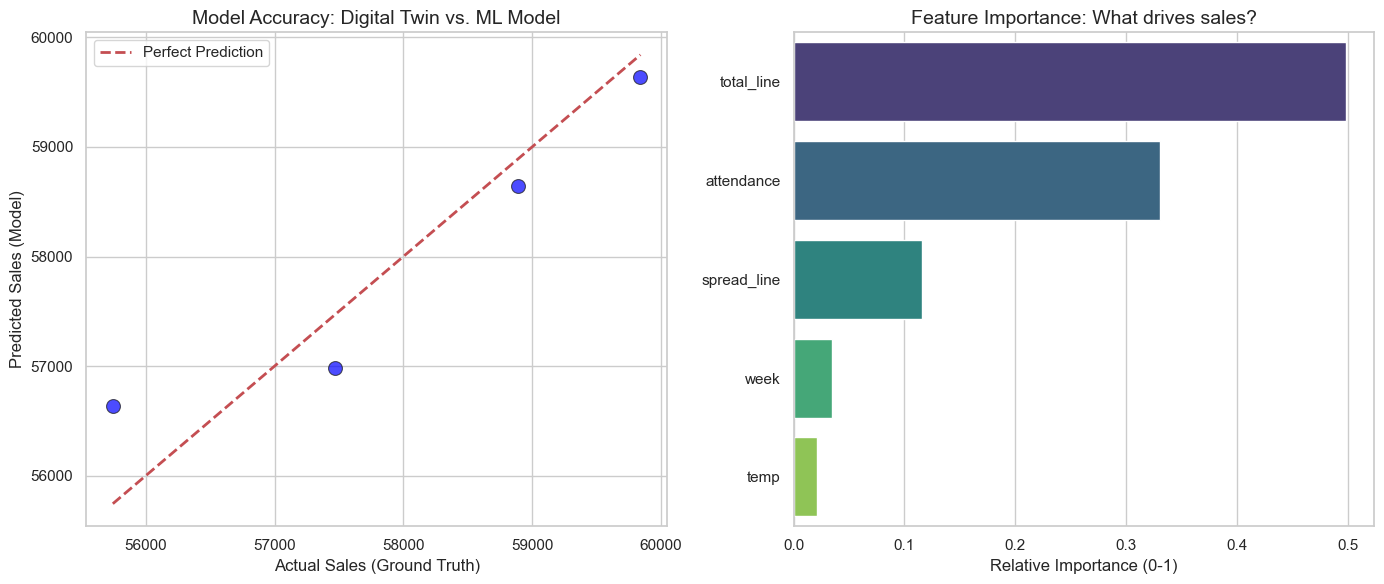

In [15]:
## CELL 15
## Visualization

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set up the visual style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))

# --- CHART 1: Accuracy (Truth vs. Prediction) ---
plt.subplot(1, 2, 1)
# Scatter plot
sns.scatterplot(x=y_test, y=y_pred, color='blue', s=100, alpha=0.7, edgecolor='k')
# Perfect prediction line (Diagonal)
min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual Sales (Ground Truth)", fontsize=12)
plt.ylabel("Predicted Sales (Model)", fontsize=12)
plt.title("Model Accuracy: Digital Twin vs. ML Model", fontsize=14)
plt.legend()

# --- CHART 2: Feature Importance (What drives demand?) ---
plt.subplot(1, 2, 2)
# Extract importance
importances = rf_model.feature_importances_
# Create DataFrame
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Bar plot
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis', hue='Feature', legend=False)
plt.title("Feature Importance: What drives sales?", fontsize=14)
plt.xlabel("Relative Importance (0-1)", fontsize=12)
plt.ylabel("")

plt.tight_layout()
plt.show()